# Fachprojekt Machine Learning
Authors: Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 1. May 2024

## Import necessary components

In [44]:
# Import the necessary libraries
import time
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the training and the testing datasets
from datasets import training_dataset, test_dataset

# Import the evaluation and the sampling function
from evaluation import evaluate
from sampling import sample

# Import the VAE model
import networks

In [45]:
# Hyperparameters
batch_size = 32 # Number of images per update of the network
num_epochs = 10 # One epoch means seeing every image of the training dataset, which consists of 50000 images
latent_dim = 150  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels

# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VAE(input_channels, latent_dim)
model.to(device)

# Optimizer selection
optimizer_option = 'adam'
learning_rate = 5e-04
clip_value = 10
accumulation_steps = 4  # Number of batches to accumulate gradients over
weight_decay = 1e-5
torch.backends.cudnn.benchmark = True
optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay =weight_decay)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay =weight_decay)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate,weight_decay =weight_decay)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,weight_decay =weight_decay)

# Learning rate scheduler parameters
lr_schedule_option = 'exponential'

scheduler = None
if lr_schedule_option == 'exponential':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

# Create data loaders for training and testing with the batch size from above.
# They can do things like multiprocessing and shuffling the order of the images.
# We can iterate over them to obtain batches of images and labels (see training loop below).
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Using device: cuda


## Training loop

Epoch 1, Mean Test Loss: 22508.570940424066, Learning Rate: 0.000500, Time: 89.24s


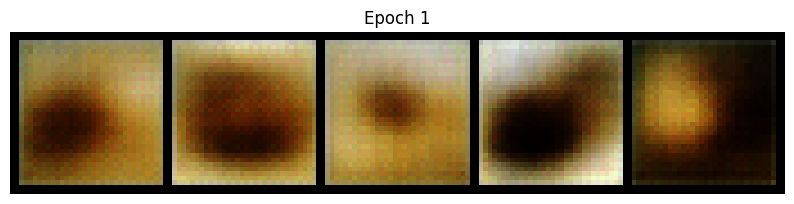

Epoch 2, Mean Test Loss: 20831.32744334313, Learning Rate: 0.000500, Time: 84.17s


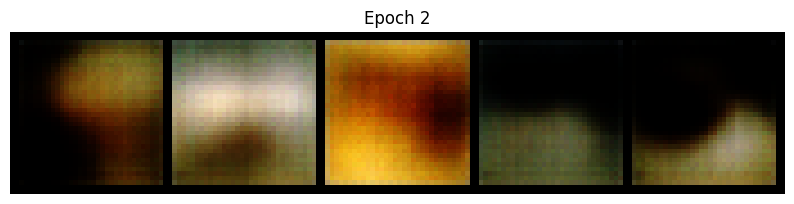

Epoch 3, Mean Test Loss: 20439.283960382676, Learning Rate: 0.000500, Time: 86.36s


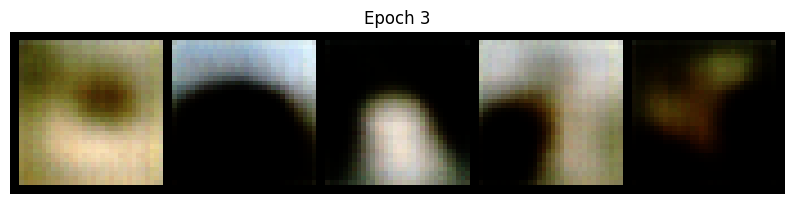

In [ ]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# We want to plot training and testing losses at the end of training
train_losses = []
test_losses = []
learning_rates = []
i = 0
# Training loop
for epoch in range(num_epochs):
  model.train()
  epoch_start_time = time.time()

  for batch_idx, (data, _) in enumerate(training_loader):
    i+=1
    data = data.to(device)
    optimizer.zero_grad(set_to_none=True)
    with torch.cuda.amp.autocast(dtype=torch.float16, enabled=True):
      # Forward pass
      recon_batch, mu, logvar = model.forward(data)

      # Compute loss
      loss = loss_function(recon_batch, data, mu, logvar)
      train_losses.append(loss)

    # Backward pass
    scaler.scale(loss).backward()

    # Gradient clipping
   #' torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

    # Optimization step
    scaler.step(optimizer)
    scaler.update()

  # Step the learning rate scheduler
  if scheduler is not None:
    lr = scheduler.get_last_lr()[0]
    scheduler.step()
  else:
    lr = learning_rate
  learning_rates.append(lr)

  # After the epoch, evaluate the accuracy on the test dataset
  mean_loss = evaluate(model, test_loader, loss_function, device)
  test_losses.append(mean_loss)

  elapsed_time = time.time() - epoch_start_time
  print(f'Epoch {epoch + 1}, Mean Test Loss: {mean_loss}, Learning Rate: {lr:.6f}, Time: {elapsed_time:.2f}s')

  # Generate and log images after each epoch
  sample(model, epoch, device, latent_dim, num_samples=5)


# Plot training and testing losses
plot_losses(train_losses, test_losses, learning_rates)


# # Plot train and test losses
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses.cpu().numpy(), label='Train Loss')
# plt.scatter(range(len(test_losses.cpu().numpy())), test_losses.cpu().numpy(), color='red', label='Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Train and Test Loss over Epochs')
# plt.show()

# # Plot learning rate over time
# plt.figure(figsize=(10, 5))
# plt.plot(learning_rates, label='Learning Rate')
# plt.xlabel('Batches')
# plt.ylabel('Learning Rate')
# plt.legend()
# plt.title('Learning Rate over Time')
# plt.show()